In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.sparse import csr_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

import IPython.display as ipd
from librosa import clicks
from scipy.io import wavfile

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.postprocessing_boeck import activations2beats
from python.models import ModelBoeck

import madmom

In [2]:
print('Torch version: {}'.format(torch.__version__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s' % (device))

Torch version: 1.0.0
Device: cpu


## Load data

In [3]:
features = pickle.load(open('../data/pickle/ballroom_features_boeck.npy', 'rb'))
labels = pickle.load(open('../data/pickle/ballroom_labels_boeck.npy', 'rb'))

In [4]:
files = sorted(os.listdir('../data/audio/Ballroom/'))
annotations = sorted(os.listdir('../data/annotations/Ballroom/'))
annotated_beats = [np.loadtxt('../data/annotations/Ballroom/' + ann, ndmin=2)[:, 0] for ann in annotations]

## Select fold

In [5]:
fold = 0

indices_test = np.loadtxt('../data/splits/Ballroom/indices_'+str(fold)+'.fold', dtype=np.int64)

## Model

In [6]:
model = ModelBoeck()
model.load_state_dict(torch.load('../models/mb_ballroom_bs-100_fold-0.pt', map_location=device))
model.eval()

ModelBoeck(
  (lstm): LSTM(120, 25, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

## Calculate predictions

In [13]:
for i, example in enumerate(indices_test):
    
    print('Evaluate file {} of {}'.format(i+1, len(indices_test)), end="\r")

    test_input = features[example].view(1, len(features[example]),-1)

    with torch.no_grad():
        out = model(test_input)

    activations = np.exp(np.array(out[0,1,:]))
    
    pred_beats = activations2beats(activations)
    
    np.savetxt('../data/predictions/fold_'+str(fold)+'/'+files[example][:-4]+'.beats', 
               pred_beats, delimiter=',',fmt='%.2f',)

## Load predictions

In [36]:
predictions = sorted(os.listdir('../data/predictions/fold_'+str(fold)+'/'))
pred_beats = [np.loadtxt('../data/predictions/fold_'+str(fold)+'/'+ pred) for pred in predictions]

In [37]:
p_scores = []
for i, example in enumerate(indices_test):
    pred = pred_beats[i]
    true = annotated_beats[example]
    p_scores.append(madmom.evaluation.beats.pscore(pred,true))

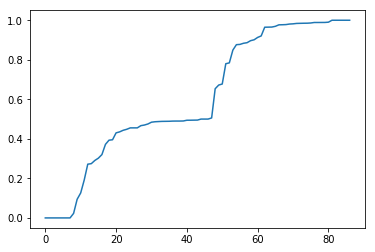

In [9]:
plt.plot(np.sort(p_scores))

In [10]:
np.mean(p_scores)

0.6052823117707538

In [15]:
indices_test[:10]

array([ 1,  8, 10, 14, 27, 31, 50, 68, 75, 79])

In [14]:
p_scores[:10]

[0.7843137254901961,
 0.3023255813953488,
 0.43023255813953487,
 0.0,
 0.29069767441860467,
 1.0,
 0.9767441860465116,
 0.9848484848484849,
 0.022988505747126436,
 0.9772727272727273]

In [41]:
files = sorted(os.listdir('../data/audio/Ballroom/'))

sr, signal = wavfile.read('../data/audio/Ballroom/' + files[example], mmap=False)

signal = signal/np.max(signal)

metronome = clicks(pred, sr=sr, length=len(signal))

test_signal = signal + metronome

ipd.Audio(test_signal, rate=sr)

Albums-Ballroom_Classics4-09.wav
Albums-Ballroom_Classics4-09.beats


/Users/juliusrichter/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


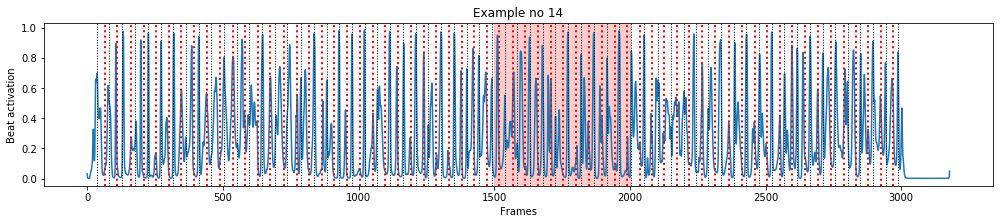

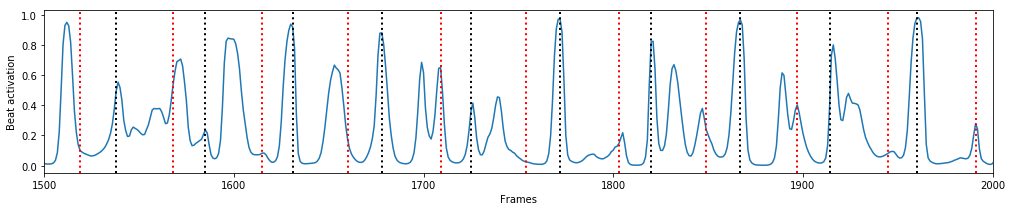

In [58]:
example = 14

test_input = features[example].view(1, len(features[example]),-1)
test_label = labels[example]

with torch.no_grad():
    out = model(test_input)

activations = np.exp(np.array(out[0,1,:]))
    
pred = activations2beats(activations)

zoom = (1500, 2000)

plt.figure(figsize=(17,3))
plt.plot(activations)
plt.xlabel('Frames')
plt.ylabel('Beat activation')
plt.axvspan(zoom[0], zoom[1], alpha=0.2, color='red')
plt.title('Example no {}'.format(example))
for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='k', linestyle=':', linewidth=1)
for pre in pred:
    plt.axvline(x=pre*100, color='r', linestyle=':', linewidth=2) 
    

plt.figure(figsize=(17,3))   
plt.plot(activations)
plt.xlabel('Frames')
plt.ylabel('Beat activation')
for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='k', linestyle=':', linewidth=2)
for pre in pred:
    plt.axvline(x=pre*100, color='r', linestyle=':', linewidth=2)    
plt.xlim(zoom);

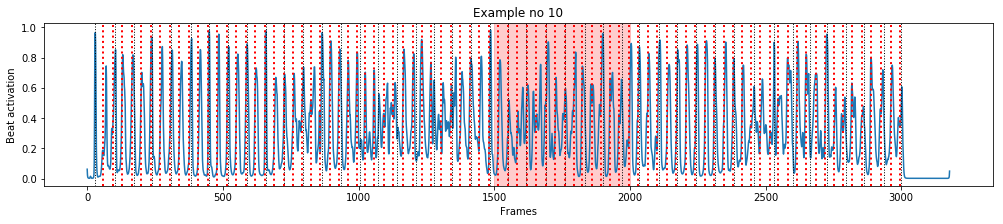

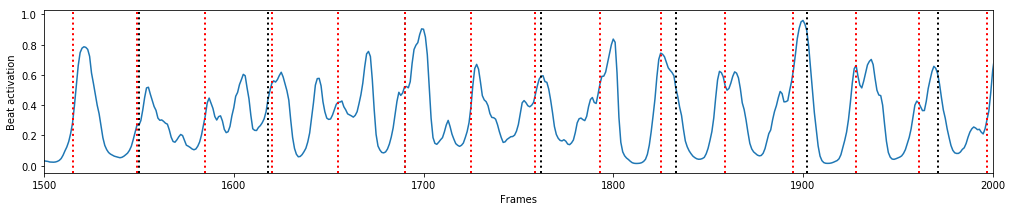

In [57]:
example = 10

test_input = features[example].view(1, len(features[example]),-1)
test_label = labels[example]

with torch.no_grad():
    out = model(test_input)

activations = np.exp(np.array(out[0,1,:]))
    
pred = activations2beats(activations)

zoom = (1500, 2000)

plt.figure(figsize=(17,3))
plt.plot(activations)
plt.xlabel('Frames')
plt.ylabel('Beat activation')
plt.axvspan(zoom[0], zoom[1], alpha=0.2, color='red')
plt.title('Example no {}'.format(example))
for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='k', linestyle=':', linewidth=1)
for pre in pred:
    plt.axvline(x=pre*100, color='r', linestyle=':', linewidth=2) 
    

plt.figure(figsize=(17,3))   
plt.plot(activations)
plt.xlabel('Frames')
plt.ylabel('Beat activation')
for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='k', linestyle=':', linewidth=2)
for pre in pred:
    plt.axvline(x=pre*100, color='r', linestyle=':', linewidth=2)    
plt.xlim(zoom);

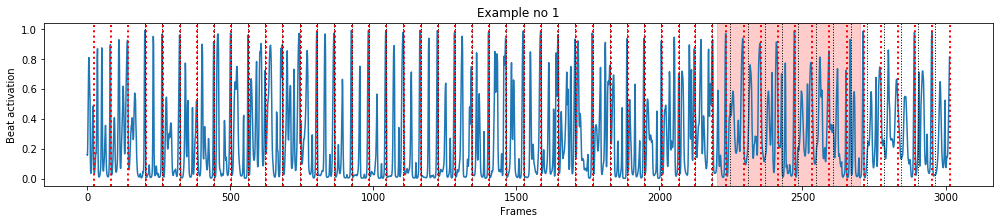

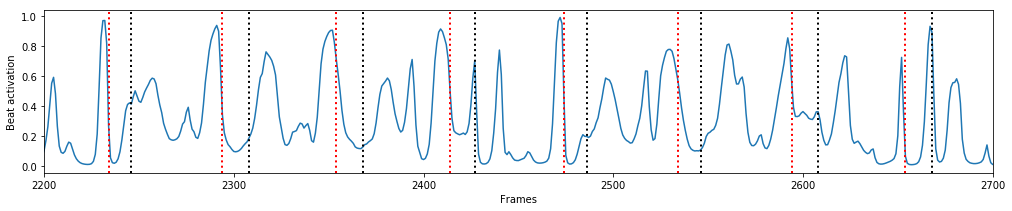

In [56]:
example = 1

test_input = features[example].view(1, len(features[example]),-1)
test_label = labels[example]

with torch.no_grad():
    out = model(test_input)

activations = np.exp(np.array(out[0,1,:]))
    
pred = activations2beats(activations)

zoom = (2200, 2700)

plt.figure(figsize=(17,3))
plt.plot(activations)
plt.xlabel('Frames')
plt.ylabel('Beat activation')
plt.axvspan(zoom[0], zoom[1], alpha=0.2, color='red')
plt.title('Example no {}'.format(example))
for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='k', linestyle=':', linewidth=1)
for pre in pred:
    plt.axvline(x=pre*100, color='r', linestyle=':', linewidth=2) 
    

plt.figure(figsize=(17,3))   
plt.plot(activations)
plt.xlabel('Frames')
plt.ylabel('Beat activation')
for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='k', linestyle=':', linewidth=2)
for pre in pred:
    plt.axvline(x=pre*100, color='r', linestyle=':', linewidth=2)    
plt.xlim(zoom);

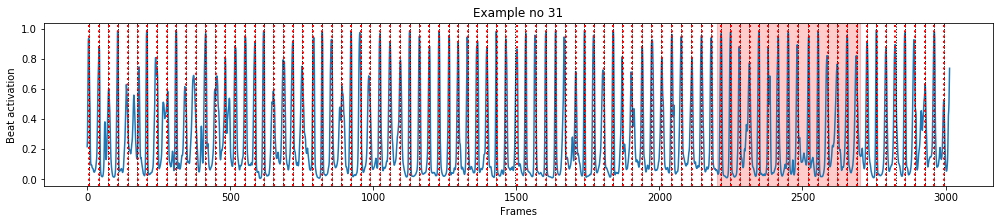

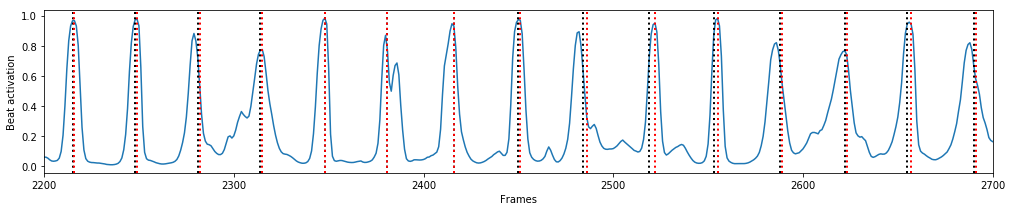

In [55]:
example = 31

test_input = features[example].view(1, len(features[example]),-1)
test_label = labels[example]

with torch.no_grad():
    out = model(test_input)

activations = np.exp(np.array(out[0,1,:]))
    
pred = activations2beats(activations)

zoom = (2200, 2700)

plt.figure(figsize=(17,3))
plt.plot(activations)
plt.xlabel('Frames')
plt.ylabel('Beat activation')
plt.axvspan(zoom[0], zoom[1], alpha=0.2, color='red')
plt.title('Example no {}'.format(example))
for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='k', linestyle=':', linewidth=1)
for pre in pred:
    plt.axvline(x=pre*100, color='r', linestyle=':', linewidth=2) 
    

plt.figure(figsize=(17,3))   
plt.plot(activations)
plt.xlabel('Frames')
plt.ylabel('Beat activation')
for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='k', linestyle=':', linewidth=2)
for pre in pred:
    plt.axvline(x=pre*100, color='r', linestyle=':', linewidth=2)    
plt.xlim(zoom);

In [63]:
madmom.evaluation.beats.pscore(pred_beats, true_beats)

0.125

In [22]:
test_input = features[300].view(1, len(features[300]),-1)

with torch.no_grad():
    out = model(test_input)

activations = np.exp(np.array(out[0,1,:]))
    
pred_beats = activations2beats(activations)